# Imports

In [1]:
import pandas as pd
import numpy as np

# loading bar
from tqdm.notebook import tqdm

# ML
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
    ## knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
    ## linear regression
from sklearn.linear_model import LinearRegression
    ## polynomial
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV
    ## decision tree
from sklearn import tree


# visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

# Contents

1. [Data Reading](#Data_Reading)
2. [PCA](#PCA)
    - [Scree Plot](#Scree-Plot)
    - [PCs Composition](#PCs-Composition)
    - [Covariance Matrices](#Covariance-Matrices)
3. [Prediction Models](#Prediction-Models)
    - [KNN](#KNN)
    - [Multivariate Linear Regression](#Multivariate-Linear-Regression)
    - [Polynomial Features](#Polynomial-Features)
        - [Ridge and Cross-Validation](#Ridge-and-Cross-Validation)

# Date Reading

In [2]:
world_metrics_path = "./data/world_metrics.csv"
world_metrics = pd.read_csv(world_metrics_path)

In [3]:
world_metrics.head()

,country,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,bmi,basic_water,pop_mils,...,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,hf_score,happiness_score
0,Angola,62.63262,17.34829,237.9694,0.057900,0.007520,5.38006,23.3,55.08428,20.82,...,7.500000,6.111324,6.496685,2.963635,5.606605,5.264754,5.518500,5.17,5.640662,3.866
1,Burundi,60.09811,16.59126,290.1858,0.052420,0.006450,3.88586,21.7,60.20415,9.85,...,5.833333,4.414134,6.115441,3.495487,7.585471,6.110770,6.271879,5.92,5.167067,2.905
2,Benin,61.08568,17.20543,242.3741,0.066690,0.009390,1.46034,23.5,66.32024,10.05,...,10.000000,7.496976,6.182575,3.822761,7.013885,6.026546,6.855929,5.98,6.738488,3.484
3,Burkina Faso,60.32101,15.48575,254.6027,0.055795,0.008635,7.10585,22.2,48.26772,16.46,...,10.000000,7.455340,5.405462,3.687657,7.121434,6.604145,7.427554,6.05,6.752670,3.739
4,Botswana,66.05297,17.42258,249.2413,0.032560,0.002040,5.14197,24.3,89.40444,2.00,...,4.250000,6.876334,6.702038,5.950516,9.056783,7.679525,7.769777,7.43,7.153167,3.974


# PCA

Principal component analysis (PCA) is a technique that transforms high-dimensions data into lower-dimensions while retaining as much information as possible. As we have 28 features that we use to predict the target variable, we want to get rid of some "unneccessary" features.

To select the most important ones, we need to work with the variance of the data. When our data has a higher variance, it holds more information.

First, we need to split the data into the features (`X`) and target variable (`y`):

In [4]:
X = world_metrics.drop(['country', 'happiness_score'], axis=1)
y = world_metrics['happiness_score']

Now, we need to apply scalling methods since our data has outliers and different ranges. We will use two main approaches: `MinMaxScaler` and `StandardScaler`.

In [5]:
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)

scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

At this momnet, we do not know, what number of principal components (PCs) we want to choose. Let us run a PCA object without limits of the number of components and fit the data:

In [6]:
pca_std = PCA()
X_std_pca_ = pca_std.fit_transform(X_std)
PC_std = np.arange(pca_std.n_components_) + 1

pca_minmax = PCA()
X_minmax_pca_ = pca_minmax.fit_transform(X_minmax)
PC_minmax = np.arange(pca_minmax.n_components_) + 1

Now, we can plot the scree plot.

## Scree Plot

**Scree Plot** is used to determine the number of PCs to keep in a PCA. We will plot it to determine the number of PC to retain that will allow to decrease the dimensionality of the data.

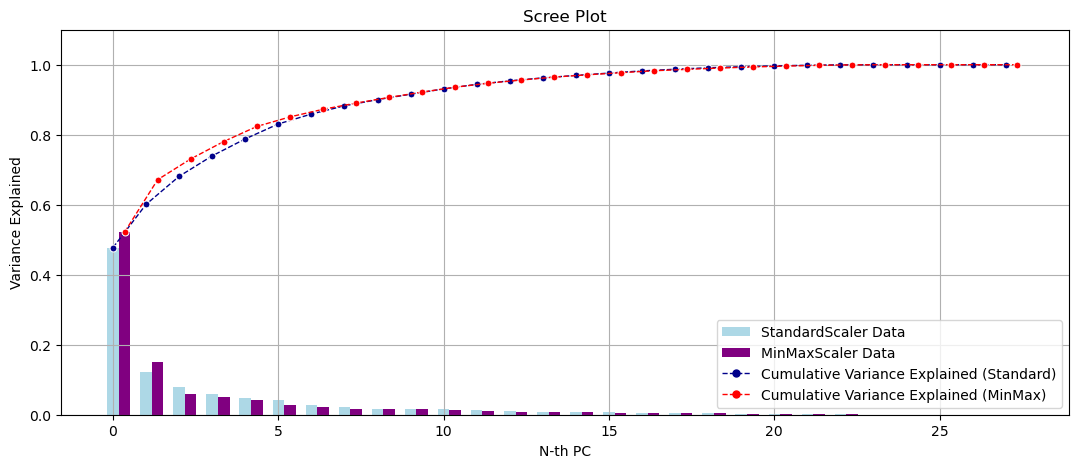

In [7]:
plt.figure(figsize=(13, 5))

std_data = pca_std.explained_variance_ratio_
minmax_data = pca_minmax.explained_variance_ratio_

bar_width = 0.35
std_pos = np.arange(len(std_data))
minmax_pos = std_pos + bar_width

std_bar = plt.bar(std_pos, std_data, width=bar_width, color='lightblue', label='Standardized Data')
minmax_bar = plt.bar(minmax_pos, minmax_data, width=bar_width, color='purple', label='MinMax Scaled Data')

std_line = sns.lineplot(x=PC_std-1, y=np.cumsum(pca_std.explained_variance_ratio_),
                        color='darkblue', linestyle='--', linewidth=1, marker='o', markersize=5)
minmax_line = sns.lineplot(x=PC_minmax-1+bar_width, y=np.cumsum(pca_minmax.explained_variance_ratio_),
                           color='red', linestyle='--', linewidth=1, marker='o', markersize=5)

plt.title('Scree Plot')
plt.xlabel('N-th PC')
plt.ylabel('Variance Explained')
plt.ylim(0, 1.1)

std_dummy = Line2D([0], [0], linestyle='--', linewidth=1, color='darkblue', marker='o', markersize=5)
minmax_dummy = Line2D([0], [0], linestyle='--', linewidth=1, color='red', marker='o', markersize=5)

plt.legend(handles=[std_bar, minmax_bar, std_dummy, minmax_dummy],
           labels=['StandardScaler Data', 'MinMaxScaler Data', 'Cumulative Variance Explained (Standard)', 'Cumulative Variance Explained (MinMax)'],
           fontsize=10)
plt.grid()
plt.show()

In general, we want to choose the number of PCs that explain most of the variance in the data while avoiding overfitting. A common rule of thumb is to choose the number of PCs that explain at least 80% of the variance.

<!-- In some cases, using too few PCs can result in loss of information, while using too many PCs can result in overfitting or noisy results. Therefore, it's often necessary to experiment with different numbers of principal components and evaluate the performance of the resulting model on a validation set. -->

As we can see, we can reach 80% of variation using 6 PCs in StandardScaler approach, while in MinMax approach we can use 5 PCs.

Let us check the share of explained variance for both scalling methods:

In [8]:
pc_mm_values = []
pc_std_values = []

for pc_mm in range(6):
    pc_mm_value = round(pca_minmax.explained_variance_ratio_[pc_mm] * 100, 2)
    pc_mm_values.append(pc_mm_value)

for pc_std in range(6):
    pc_std_value = round(pca_std.explained_variance_ratio_[pc_std] * 100, 2)
    pc_std_values.append(pc_std_value)

total_mm = sum(pc_mm_values)
total_std = sum(pc_std_values)

var_explained = pd.DataFrame({'MinMaxScaler': pc_mm_values + [total_mm],
                              'StandardScaler': pc_std_values + [total_std]},
                              index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'Total'])

var_explained

,MinMaxScaler,StandardScaler
PC1,52.16,47.76
PC2,14.98,12.34
PC3,5.93,8.01
PC4,4.98,5.85
PC5,4.30,4.85
PC6,2.73,4.26
Total,85.08,83.07


From the table above one can see the differences in the explained variance between the MinMaxScaler and StandardScaler. It can be attributed to the nature of each scaling method: for example, MinMaxScaler can be affected by outliers and the distribution of the data, while StandardScaler standardizes the data based on the mean and standard deviation of each feature, hnce, it is more robust to outliers. 

<!-- It seems that for PC1 and PC2, MinMaxScaler provides higher values compared to StandardScaler, indicating that the values of those components are relatively larger in the MinMaxScaled data compared to the StandardScaled data. This does not necessarily mean that the range of values in PC1 and PC2 is larger compared to other components. In contrast, for PC3, PC4, and PC6, StandardScaler provides higher values compared to MinMaxScaler. This suggests that the variance of those components is relatively larger in the StandardScaled data compared to the MinMaxScaled data. 
 -->
Regarding MinMaxScaler approach, one can see that PC1 explains 52.16% of the variance in the original data, while the PC2 explains 14.98% of the variance, etc. Together, the 5 components explain a total of 82.36% of the variance in the original data.

Hence we can use 5 PCs instead of 28 since they capture most of the data variance.

From the results of StandardScaler: PC1 explains 47.76% of the variance PC2 explains 12.34% of the variance, etc. Together, the first 6 components explain a total of 83.07% of the variance in the original data.

In fact, it allows us to use 6 PCs instead of 28 because they capture most of the data variance.

On top of that, we can also look at the combinations of variables that created each PC. We could use a heatmap to showcase this.

# PCs Composition

We display the squared values (using `.components_**2`) of the correlation between the PCs and features. Squaring ensures that all correlations are positive and eliminates the distinction between positive and negative correlations.

Since the squared values range from 0 to 1, the heatmaps represent the relative strength of the correlations between the PCs and features. Darker colors indicate that the corresponding features have a **higher** correlation with the PC and therefore contribute **more** to the construction of that component. On the contrast, lighter color indicates a **lower** correlation. We also use red color of the to indicate values that contribute the least (their correlation values are lowe 0.1).

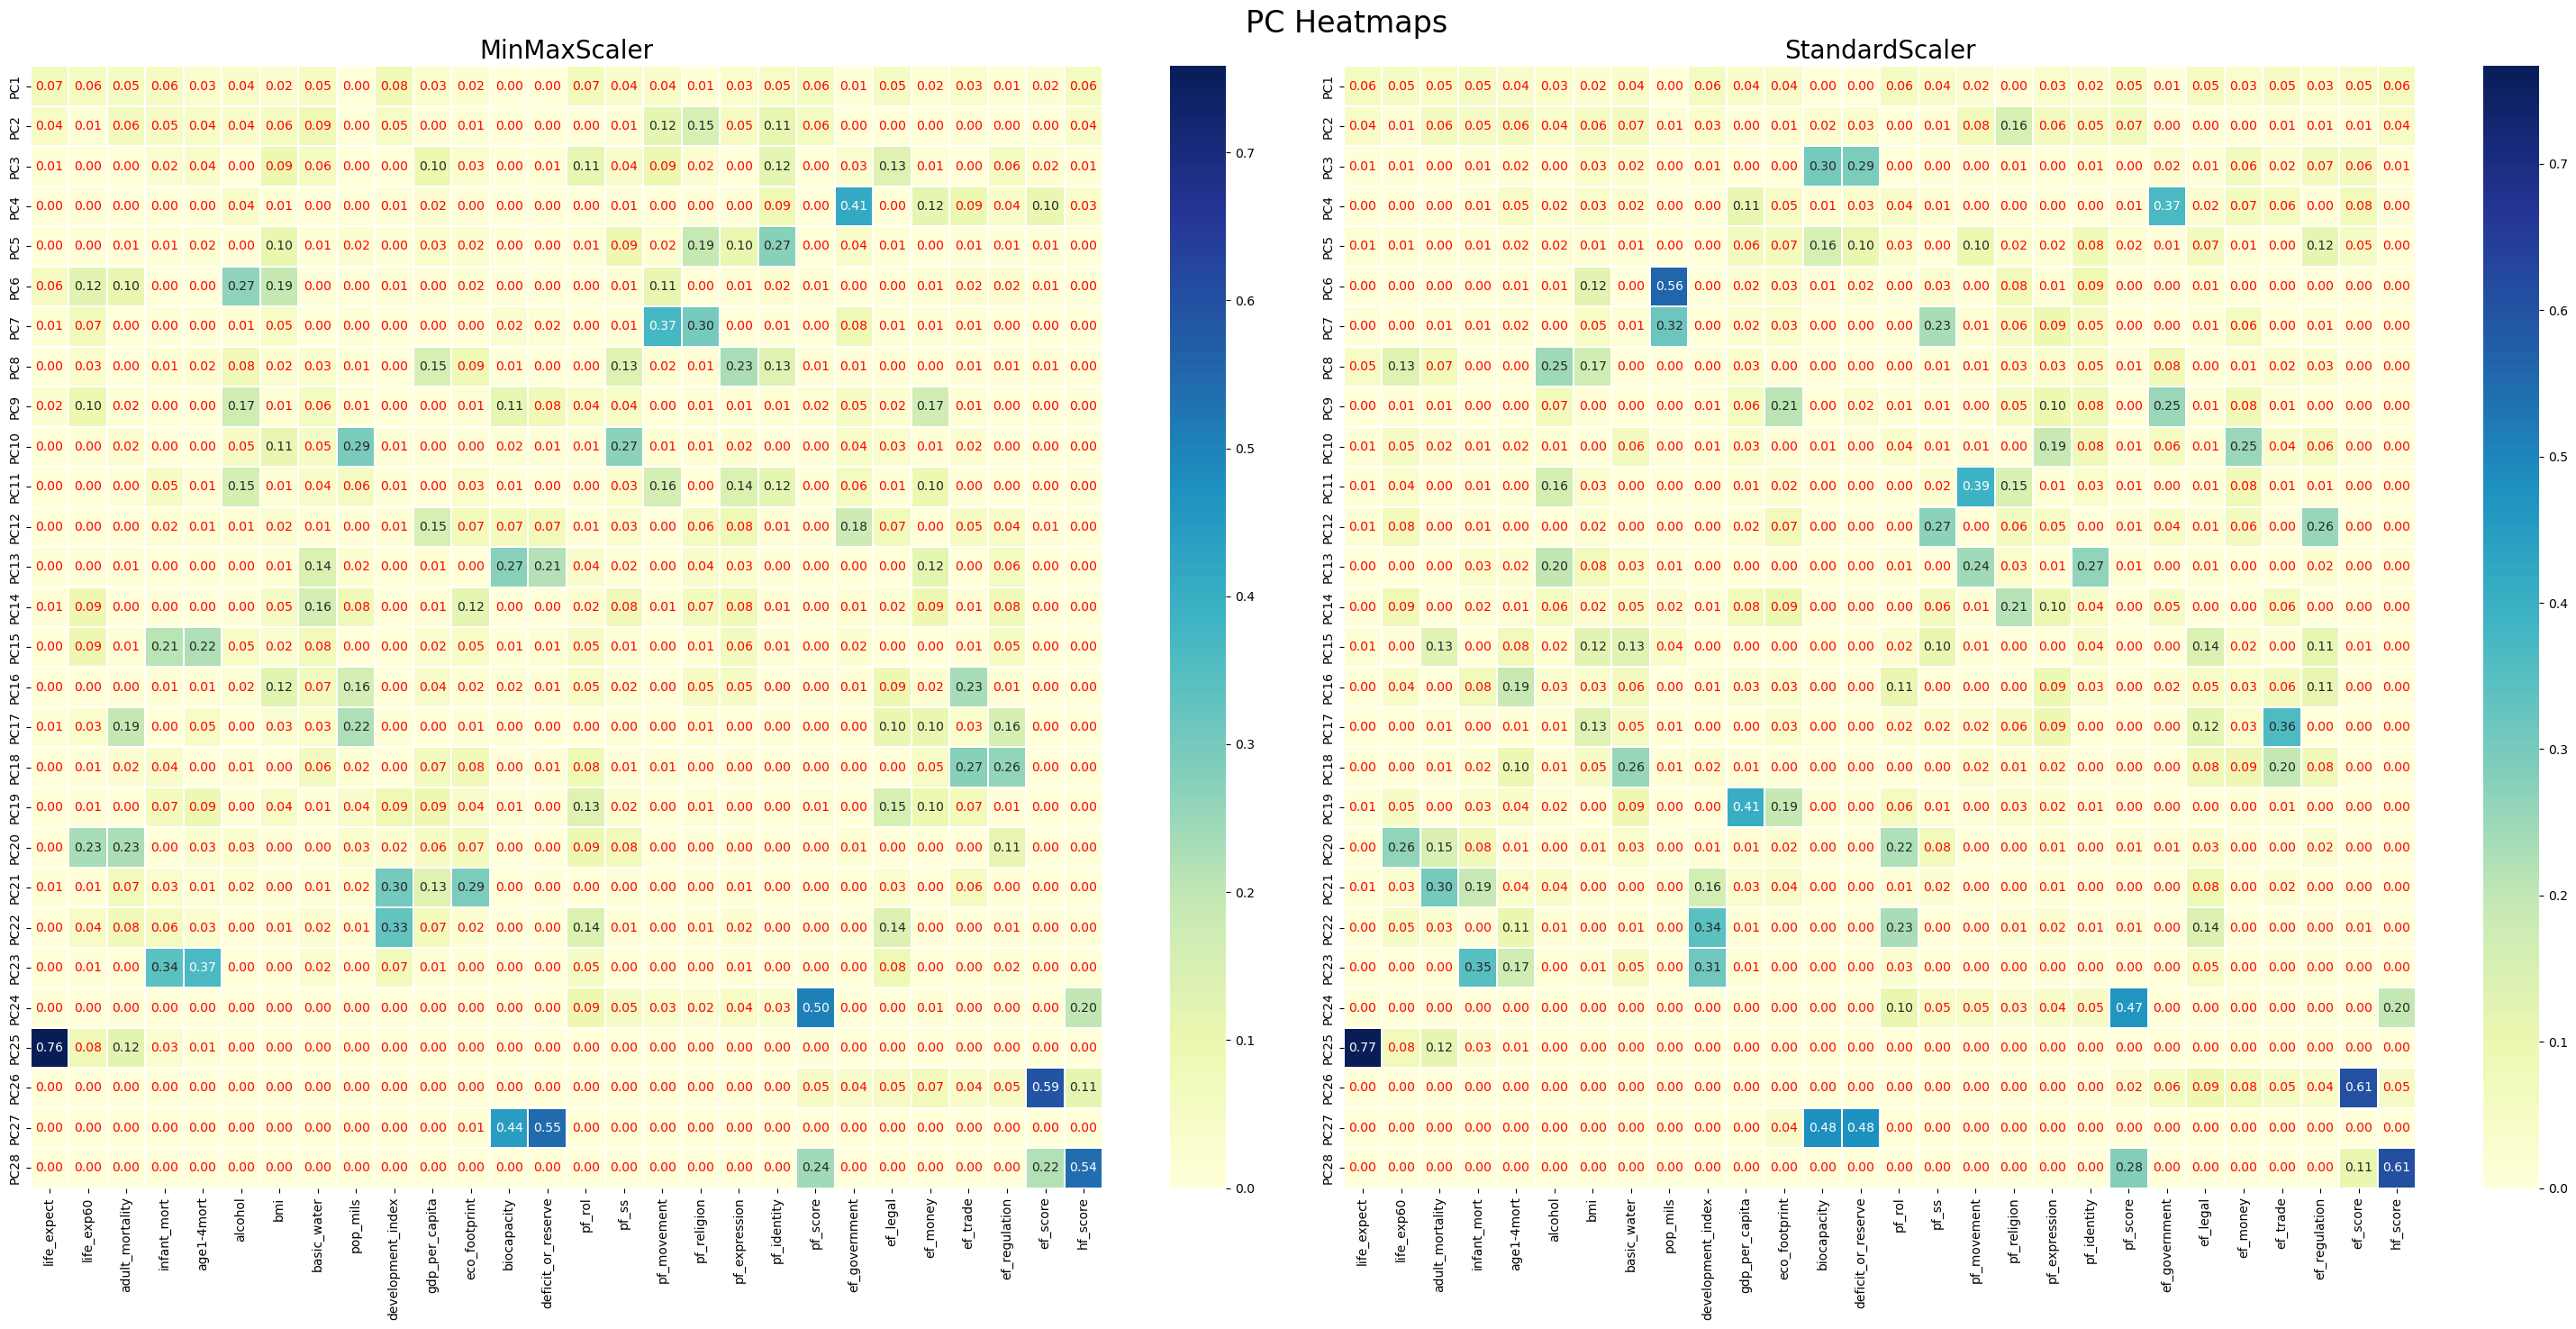

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
cmap = sns.color_palette('YlGnBu', as_cmap=True)

max_value = 0.1

heatmaps = [sns.heatmap(pca_minmax.components_**2,
                        yticklabels=["PC"+str(x) for x in range(1, pca_minmax.n_components_+1)],
                        xticklabels=list(world_metrics.columns[1:-1]),
                        annot=True, fmt='.2f',
                        linewidths=0.1,
                        cmap=cmap,
                        ax=ax[i]) for i, pca_minmax in enumerate([pca_minmax, pca_std])]

for i, heatmap in enumerate(heatmaps):
    for text in heatmap.texts:
        value = float(text.get_text())
        if value < max_value:
            text.set_color('red')

    ax[i].set_title(["MinMaxScaler", "StandardScaler"][i], fontsize=20)

fig.suptitle('PC Heatmaps', fontsize=24)
plt.tight_layout()
plt.show()

Here are some interesting findings from the heatmaps above:

1. We do observe that most of the times, features do not contribute that much to the PC formation (they are written in red). It is especially the case of PC1 in both scalling approaches: each festure contribute to a small portion lower than 0.1.
2. Most often, PCs are built on the base of a several features. For example, here are the main features used to form PC2:

|MinMaxScaler|value|StandardScaler|value|
|---|---|---|---|
|`pf_movement`|0.12|||
|`pf_religion`|0.15|`pf_religion`|0.16|
|`pf_identity`|0.11|||

However, even in such cases the contribution of these features are quite low.

3. In some PCs we do observe the prominent dominance of one/several feature(s). For example, PC25, PC26, PC27, PC28:

|PCs|MinMaxScaler|value|StandardScaler|value|
|---|---|---|---|---|
|**PC25**|`life_expect`|0.76|`life_expect`|0.77|
||`adult_mortality`|0.12|`adult_mortality`|0.12|
|**PC26**|`ef_score`|0.59|`ef_score`|0.61|
||`hf_score`|0.11|||
|**PC27**|`biocapacity`|0.44|`biocapacity`|0.48|
||`deficit_or_reserve`|0.55|`deficit_or_reserve`|0.48|
|**PC28**|`pf_score`|0.24|`pf_score`|0.28|
||`ef_score`|0.22|`ef_score`|0.11|
||`hf_score`|0.54|`hf_score`|0.61|

4. While it is tempting to choose those features that have higher correlation values, we must stay strong and choose higher variance PCs. Higher correlation values indicate a stronger **linear** relationship between features and PCs. However, it is not the sole criterion for feature selection. When selecting PCs, the primary criterion is to choose PCs that explain the most variance in the data that indicates the better spread (dispersion) of the data. Therefore, **we need to choose PCs with higher variance, not higher correlation values**. To do so, we need to use [Scree Plot](#Scree-Plot) depicted earlier. Another strategy, to compute covariance matrices:

## Covariance Matrices

As PCA aims to find a new set of orthogonal variables (PCs) that capture the maximum variance in the data, the eigenvectors of the covariance matrix represent these PCs, while the corresponding eigenvalues indicate the amount of variance explained by each component. The eigenvectors define the direction of the PCs, and the eigenvalues determine their relative importance.

By analyzing the covariance matrix, PCA identifies the PCs with the highest eigenvalues, which explains the most significant amount of variance in the data. These PCs will be used to represent the original dataset in a lower-dimensional space, while preserving the most important information. PCA utilizes the eigenvectors of the covariance matrix to construct the transformation matrix that decorrelates the variables.

In [10]:
cov_matrix_std = np.cov(X_std.T)
cov_matrix_minmax = np.cov(X_minmax.T)

In [11]:
eigenvalues_std, eigenvectors_std = np.linalg.eig(cov_matrix_std)
eigenvalues_minmax, eigenvectors_minmax = np.linalg.eig(cov_matrix_minmax)

In [12]:
# sort eigenvalues and select top 6 PCs for Standard
top_indices_std = np.argsort(eigenvalues_std)[::-1][:6]
top_eigenvalues_std = eigenvalues_std[top_indices_std]
top_eigenvectors_std = eigenvectors_std[:, top_indices_std]

# sort eigenvalues and select top 5 PCs for MinMax
top_indices_minmax = np.argsort(eigenvalues_minmax)[::-1][:5]
top_eigenvalues_minmax = eigenvalues_minmax[top_indices_minmax]
top_eigenvectors_minmax = eigenvectors_minmax[:, top_indices_minmax]

Now we can create the feature matrices for both scallings.

In [13]:
feature_matrix_std = X_std.dot(top_eigenvectors_std)
feature_matrix_minmax = X_minmax.dot(top_eigenvectors_minmax)

Let us visualise the obtained covariance matrices. As before, we used lightblue color for StandardScaler (Std) and purple for MinMaxScaler (MM).

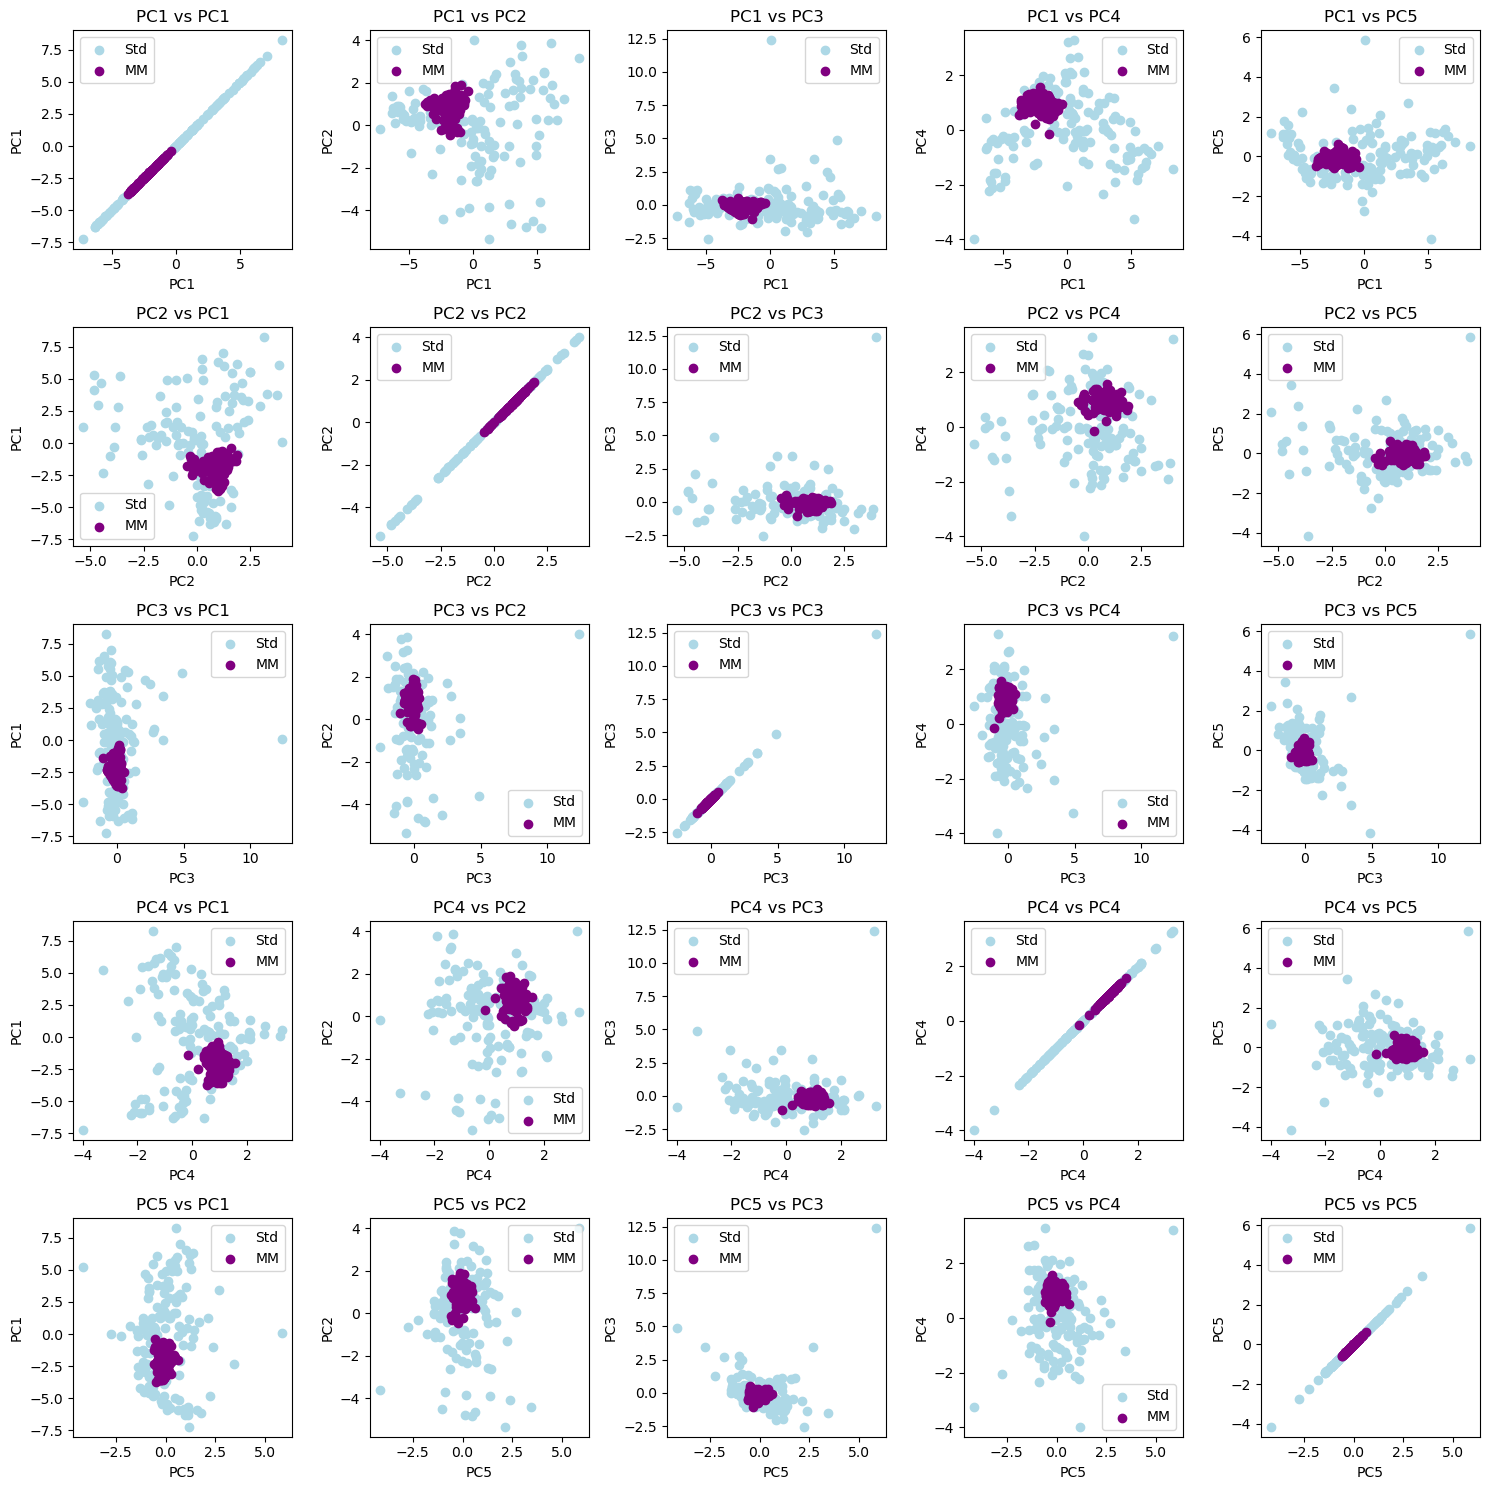

In [14]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        ax[i, j].scatter(feature_matrix_std[:, i], feature_matrix_std[:, j], color='lightblue', label='Std')
        ax[i, j].scatter(feature_matrix_minmax[:, i], feature_matrix_minmax[:, j], color='purple', label='MM')
        ax[i, j].set_xlabel(f'PC{i+1}')
        ax[i, j].set_ylabel(f'PC{j+1}')
        ax[i, j].set_title(f'PC{i+1} vs PC{j+1}')
        ax[i, j].legend()

plt.tight_layout()
plt.show()

We can clearly see the difference betweeen 2 scalling methods. MinMaxScaler datapoints are more concentrated, while StandardScaler datapoints are more spreaded.

As we prepared feature matrices, we can now apply different models to see how well they will perform.

# Prediction Models

As in previous parts, we will apply 4 predicting models:
- KNN
- Multivariate Linear Regression
- Polynomial Feature Regression

and then compare them vased on their performance (MAE, MSE, $R^2$, adjusted $R^2$).

## KNN

First, we need to split the data into training and testing sets. We will use two different `random_state` parameters (88 for StandardScaler, 99 for MinMaxScaler) to separate two strategies we want to analyse.

In [15]:
X_std_train_knn, X_std_test_knn, y_std_train_knn, y_std_test_knn = train_test_split(feature_matrix_std, y, test_size=0.2, random_state=88)
X_minmax_train_knn, X_minmax_test_knn, y_minmax_train_knn, y_minmax_test_knn = train_test_split(feature_matrix_minmax, y, test_size=0.2, random_state=99)

Afterwards, we need to create and train the KNN models:

In [16]:
knn_std = KNeighborsRegressor(n_neighbors=4)
knn_std.fit(X_std_train_knn, y_std_train_knn)

KNeighborsRegressor(n_neighbors=4)

In [17]:
knn_minmax = KNeighborsRegressor(n_neighbors=4)
knn_minmax.fit(X_minmax_train_knn, y_minmax_train_knn)

KNeighborsRegressor(n_neighbors=4)

Once the model is trained, we can use it to make predictions.

In [18]:
y_train_pred_std_knn = knn_std.predict(X_std_train_knn)
y_train_pred_minmax_knn = knn_minmax.predict(X_minmax_train_knn)

y_test_pred_std_knn = knn_std.predict(X_std_test_knn)
y_test_pred_minmax_knn = knn_minmax.predict(X_minmax_test_knn)

The most important part is to assess the performance of the model by comparing the predicted values (`y_pred_std_knn` or `y_pred_minmax_knn`) with the actual values (`y_std_test_knn`, `y_minmax_test_knn`).

In [19]:
def calculate_metrics(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, model_name, scaler_used):
    """
    Computes the statistics: MAE, MSE, R^2, adjusted R^2 
    on the training and test sets.

    Args:
    X_train: training set features
    X_test: test set features
    y_train: training set target variable
    y_test: test set target variable
    y_train_pred: model train set predictions
    y_test_pred: model test set predictions
    model_name: prediction model usde (string)
    scaler_used: scaling approach used before (string)

    Returns:
    Dataframe with MAE, MSE, R^2, adjusted R^2 on the training and test sets.
    """
    
    # train set
    mae_train = round(mean_absolute_error(y_train, y_train_pred), 4)
    mse_train = round(mean_squared_error(y_train, y_train_pred), 4)
    r2_train = round(r2_score(y_train, y_train_pred), 4)
    adj_r2_train = round(1 - (1 - r2_train) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1)), 4)

    # test set
    mae_test = round(mean_absolute_error(y_test, y_test_pred), 4)
    mse_test = round(mean_squared_error(y_test, y_test_pred), 4)
    r2_test = round(r2_score(y_test, y_test_pred), 4)
    adj_r2_test = round(1 - (1 - r2_test) * ((X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)), 4)

    # metrics dataframe
    model_metrics = pd.DataFrame({'train': [mae_train, mse_train, r2_train, adj_r2_train],
                                 'test': [mae_test, mse_test, r2_test, adj_r2_test]},
                                 index=['MAE', 'MSE', 'R^2', 'adj. R^2'])
    
    model_metrics.columns.name = model_name + scaler_used
    
    return model_metrics

In [20]:
display(calculate_metrics(X_std_train_knn, X_std_test_knn, 
                          y_std_train_knn, y_std_test_knn, 
                          y_train_pred_std_knn, y_test_pred_std_knn, 
                          "KNN_", "StandardScaler"))
display(calculate_metrics(X_minmax_train_knn, X_minmax_test_knn, 
                          y_minmax_train_knn, y_minmax_test_knn, 
                          y_train_pred_minmax_knn, y_test_pred_minmax_knn, 
                          "KNN_", "MinMaxScaler"))

KNN_StandardScaler,train,test
MAE,0.3545,0.4510
MSE,0.2112,0.2965
R^2,0.8330,0.7257
adj. R^2,0.8232,0.6473


KNN_MinMaxScaler,train,test
MAE,0.3590,0.4446
MSE,0.2220,0.3046
R^2,0.8282,0.7091
adj. R^2,0.8199,0.6430


Based on the results above, we can analyze the performance of the KNN model:

1. MSE: lower values indicate better model performance.
    - Train sets perform better using StandardScaler
    - Test sets perform better using MinMaxScaller
2. MAE: lower values indicate better model performance.
    - MinMaxScaler should be prefered over StandardScaler
3. $R^2$: greater values indicate better model fit and predictive power.
    - StandardScaler model explains more variance in the target variable compared to MinMaxScaller.
4. Adjusted R-squared:.
    - StandardScaler model explains more variance in the target variable compared to MinMaxScaller.

## Multivariate Linear Regression

In [21]:
X_std_train_reg, X_std_test_reg, y_std_train_reg, y_std_test_reg = train_test_split(feature_matrix_std, y, test_size=0.2, random_state=88)
X_minmax_train_reg, X_minmax_test_reg, y_minmax_train_reg, y_minmax_test_reg = train_test_split(feature_matrix_minmax, y, test_size=0.2, random_state=99)

In [22]:
reg_std = LinearRegression()
reg_std.fit(X_std_train_reg, y_std_train_reg)

LinearRegression()

In [23]:
reg_minmax = LinearRegression()
reg_minmax.fit(X_minmax_train_reg, y_minmax_train_reg)

LinearRegression()

In [24]:
y_train_pred_std_reg = reg_std.predict(X_std_train_reg)
y_train_pred_minmax_reg = reg_minmax.predict(X_minmax_train_reg)

y_test_pred_std_reg = reg_std.predict(X_std_test_reg)
y_test_pred_minmax_reg = reg_minmax.predict(X_minmax_test_reg)

In [25]:
display(calculate_metrics(X_std_train_reg, X_std_test_reg, 
                          y_std_train_reg, y_std_test_reg, 
                          y_train_pred_std_reg, y_test_pred_std_reg, 
                          "LinReg_", "StandardScaler"))
display(calculate_metrics(X_minmax_train_reg, X_minmax_test_reg, 
                          y_minmax_train_reg, y_minmax_test_reg, 
                          y_train_pred_minmax_reg, y_test_pred_minmax_reg, 
                          "LinReg_", "MinMaxScaler"))

LinReg_StandardScaler,train,test
MAE,0.4705,0.6200
MSE,0.3358,0.5711
R^2,0.7344,0.4717
adj. R^2,0.7188,0.3208


LinReg_MinMaxScaler,train,test
MAE,0.5123,0.5478
MSE,0.3683,0.4427
R^2,0.7149,0.5772
adj. R^2,0.7011,0.4811


Overall, it seems that using linear regression instead of KNN model doesn't improve the performance: MSE and MAE values are higher -> the errors are higher. At the same time, $R^2$ are lower, meaning that the model explains less variance than KNN.

## Polynomial Features

In [26]:
X_std_train_poly, X_std_test_poly, y_std_train_poly, y_std_test_poly = train_test_split(feature_matrix_std, y, test_size=0.2, random_state=88)
X_minmax_train_poly, X_minmax_test_poly, y_minmax_train_poly, y_minmax_test_poly = train_test_split(feature_matrix_minmax, y, test_size=0.2, random_state=99)

We want to plot the evolution of the MSE on the training and test sets for a polynomial feature regression model when the degree goes from 2 to 10 to decide, which degree should we choose.

In [27]:
def poly_reg(degree, X_train, y_train, X_test, y_test, scaler_used):
    """
    Computes the statistics: MAE, MSE, R^2, adjusted R^2 
    on the training and test sets.

    Args:
    X_train: training set features
    X_test: test set features
    y_train: training set target variable
    y_test: test set target variable
    scaler_used: scaling approach used before (string)

    Returns:
    Dataframe with MAE, MSE, R^2, adjusted R^2 on the training and test sets.
    """

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)

    y_train_pred = lin_reg.predict(X_train_poly)
    y_test_pred = lin_reg.predict(X_test_poly)
    
    # metrics: train set
    mae_train = round(mean_absolute_error(y_train, y_train_pred), 4)
    mse_train = round(mean_squared_error(y_train, y_train_pred), 4)
    r2_train = round(r2_score(y_train, y_train_pred), 4)
    adj_r2_train = round(1 - (1 - r2_train) * ((X_train_poly.shape[0] - 1) / (X_train_poly.shape[0] - X_train_poly.shape[1] - 1)), 4)

    # metrics: test set
    mae_test = round(mean_absolute_error(y_test, y_test_pred), 4)
    mse_test = round(mean_squared_error(y_test, y_test_pred), 4)
    r2_test = round(r2_score(y_test, y_test_pred), 4)
    adj_r2_test = round(1 - (1 - r2_test) * ((X_test_poly.shape[0] - 1) / (X_test_poly.shape[0] - X_test_poly.shape[1] - 1)), 4)

    # metrics dataframe
    poly_metrics = pd.DataFrame({'train': [mae_train, mse_train, r2_train, adj_r2_train],
                                 'test': [mae_test, mse_test, r2_test, adj_r2_test]},
                                 index=['MAE', 'MSE', 'R^2', 'adj. R^2'])
    
    poly_metrics.columns.name = scaler_used
    
    return poly_metrics

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

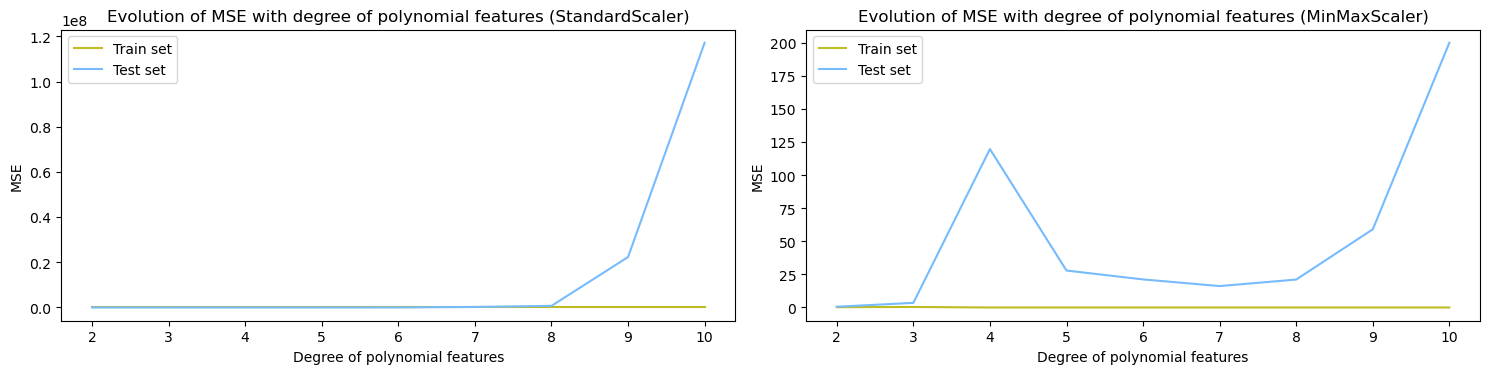

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

datasets = [(X_std_train_poly, y_std_train_poly, X_std_test_poly, y_std_test_poly, "StandardScaler"),
            (X_minmax_train_poly, y_minmax_train_poly, X_minmax_test_poly, y_minmax_test_poly, "MinMaxScaler")]

for i, (X_train_poly, y_train_poly, X_test_poly, y_test_poly, scaler_name) in enumerate(datasets):
    train_mse = []
    test_mse = []

    for degree in tqdm(range(2, 11)):
        poly_metrics = poly_reg(degree, X_train_poly, y_train_poly, X_test_poly, y_test_poly, scaler_name)
        train_mse.append(poly_metrics.loc['MSE', 'train'])
        test_mse.append(poly_metrics.loc['MSE', 'test'])

    degrees = range(2, 11)
    axs[i].plot(degrees, train_mse, label='Train set', color='tab:olive')
    axs[i].plot(degrees, test_mse, label='Test set', color='xkcd:sky blue')
    axs[i].set_xlabel('Degree of polynomial features')
    axs[i].set_ylabel('MSE')
    axs[i].set_title(f'Evolution of MSE with degree of polynomial features ({scaler_name})')
    axs[i].legend()

plt.tight_layout()
plt.show()

Typically, we want to choose the degree that provides the lowest MSE on the test set (blue line), as this indicates that the model generalizes well to new data. In this case, we should prefer 2 over other degrees.

In [29]:
# polynom without ridge and cross-validation
display(poly_reg(2, X_std_train_poly, y_std_train_poly, X_std_test_poly, y_std_test_poly, "StandardScaler"))
display(poly_reg(2, X_minmax_train_poly, y_minmax_train_poly, X_minmax_test_poly, y_minmax_test_poly, "MinMaxScaler"))

StandardScaler,train,test
MAE,0.4305,0.6493
MSE,0.3228,0.7314
R^2,0.7447,0.3234
adj. R^2,0.6553,19.2682


MinMaxScaler,train,test
MAE,0.4015,0.5623
MSE,0.2394,0.5758
R^2,0.8147,0.4501
adj. R^2,0.7700,-1.4746


Polynomial function without ridge and cross-validation doesn't provide better performance compared to KNN

### Ridge and Cross-Validation

Now, we want to build, train, and evaluate a polynomial features regression model with Ridge regularization, and cross validation settings.

In [30]:
def ridge_regression(degree, X_train, y_train, X_test, y_test, scaler_used, cross_validation=False):
    """
    Computes the statistics: MAE, MSE, R^2 on the train and test sets
    of a polynomial feature regression model with Ridge regularization and
    optional cross-validation.

    Args:
    degree: degree of polynomial features (integer)
    X_train: training set features
    y_train: training set target variable
    X_test: test set features
    y_test: test set target variable
    scaler_used: scaling approach used before (string)
    cross_validation: whether to perform cross-validation: default False (boolean)

    Returns:
    Dataframe with MAE, MSE, R2 on the training and test sets.
    """

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    if cross_validation:
        ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, fit_intercept=False)
    else:
        ridge_model = Ridge(alpha=1.0, fit_intercept=False)

    ridge_model.fit(X_train_poly, y_train)

    # metrics: train set
    predictions_train = ridge_model.predict(X_train_poly)
    mae_train = round(mean_absolute_error(y_train, predictions_train), 4)
    mse_train = round(mean_squared_error(y_train, predictions_train), 4)
    r2_train = round(r2_score(y_train, predictions_train), 4)
    adj_r2_train = round(1 - (1 - r2_train) * ((X_train_poly.shape[0] - 1) / (X_train_poly.shape[0] - X_train_poly.shape[1] - 1)), 4)

    # metrics: test set
    predictions_test = ridge_model.predict(X_test_poly)
    mae_test = round(mean_absolute_error(y_test, predictions_test), 4)
    mse_test = round(mean_squared_error(y_test, predictions_test), 4)
    r2_test = round(r2_score(y_test, predictions_test), 4)
    adj_r2_test = round(1 - (1 - r2_test) * ((X_test_poly.shape[0] - 1) / (X_test_poly.shape[0] - X_test_poly.shape[1] - 1)), 4)
    
    # metrics dataframe
    if cross_validation:
        ridge_metrics = pd.DataFrame({'train': [mae_train, mse_train, r2_train, adj_r2_train],
                                      'test': [mae_test, mse_test, r2_test, adj_r2_test]},
                                      index=['MAE', 'MSE', 'R^2', 'adj. R^2'])
    else:
        ridge_metrics = pd.DataFrame({'train': [mae_train, mse_train, r2_train, adj_r2_train],
                                      'test': [mae_test, mse_test, r2_test, adj_r2_test]},
                                      index=['MAE', 'MSE', 'R^2', 'adj. R^2'])
    
    ridge_metrics.columns.name = scaler_used

    return ridge_metrics

In [31]:
# ridge without cross-validation
display(ridge_regression(2, X_std_train_poly, y_std_train_poly, X_std_test_poly, y_std_test_poly, "StandardScaler"))
display(ridge_regression(2, X_minmax_train_poly, y_minmax_train_poly, X_minmax_test_poly, y_minmax_test_poly, "MinMaxScaler"))

StandardScaler,train,test
MAE,0.3907,0.5371
MSE,0.2498,0.4594
R^2,0.8025,0.5750
adj. R^2,0.7334,12.4750


MinMaxScaler,train,test
MAE,0.4237,0.5785
MSE,0.2722,0.4944
R^2,0.7893,0.5279
adj. R^2,0.7384,-1.1244


At this stage, KNN still performs better.

In [32]:
# ridge with cross-validation
display(ridge_regression(2, X_std_train_poly, y_std_train_poly, X_std_test_poly, y_std_test_poly, "StandardScaler", cross_validation=True))
display(ridge_regression(2, X_minmax_train_poly, y_minmax_train_poly, X_minmax_test_poly, y_minmax_test_poly, "MinMaxScaler", cross_validation=True))

StandardScaler,train,test
MAE,0.3773,0.6106
MSE,0.2356,0.5571
R^2,0.8137,0.4846
adj. R^2,0.7485,14.9158


MinMaxScaler,train,test
MAE,0.4237,0.5785
MSE,0.2722,0.4944
R^2,0.7893,0.5279
adj. R^2,0.7384,-1.1244


StandardScaler:
- it seems, that for the train set, ridge with cross-validation approach works a bit better than KNN model (MSE, MAE are lower, $R^4$ is a bit higher).
- at the same time, for the test set MAE and MSE are higher (mianing, the errors are higher), and $R^2$ is lower.
    
Generally, we would still stick to KNN approach.

## Decision Tree

First, we need to prepare the data and divide the dataset into a training and a testing set.

In [33]:
X_std = feature_matrix_std
X_minmax = feature_matrix_minmax

y = world_metrics['happiness_score']

In [34]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size=0.2, random_state=88)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax, y, test_size=0.2, random_state=99)

Now we need to create the decision tree model.

In [35]:
my_tree_std = tree.DecisionTreeClassifier(max_depth=5)
my_tree_minmax = tree.DecisionTreeClassifier(max_depth=5)

Now let's train and predict:

In [36]:
# my_tree_std.fit(X_train_std, y_train_std)
# my_tree_minmax.fit(X_train_minmax, y_train_minmax)

# y_pred_std = my_tree_std.predict(X_test_std)
# y_pred_minmax = my_tree_minmax.predict(X_test_minmax)